# <span style="color:green"> Numerical Simulation Laboratory (NSL) exercises 10 Results</span>

## 10.1


In the following plot we present our results with SA and GA algorithm with the following set up:
##### Simulated Annealing

- Numbers of iterations set at $3\times 10^3$
- Temperature decreasing from $300\to 0$
- Monte Carlo steps added in every iteration set at $10^3$

##### Genetic Algorithm
- The size of our population (series of possible travels in this case) set at $1\times10^3$
- The numbers of generations set at 100
- The Mutation probability set at 10%
- The Crossover probability set at 50%
- The power law exponential for the selection operator $p = 2$

In [50]:
import numpy as np
from matplotlib import pyplot as plt
import subprocess
import os
import re


pathGA = os.path.join(os.getcwd(), "9")
pathSA = os.path.join(os.getcwd(), "10/simulated_annealing")
#Create imput file to run the TSP program with GA algorithm
def create_input_file_GA(pop_size, num_gen, mutation_prob, xover_prob, powerlaw_exp):
    with open(f"{pathGA}/config", 'w') as new_config:
        with open(f"{pathGA}/config.orig", 'r') as template_config:
            config = template_config.read()
            config = re.sub("{POP_SIZE}", str(pop_size), config)
            config = re.sub("{NUM_GENERATIONS}", str(num_gen), config)
            config = re.sub("{MUTATION_PROB}", str(mutation_prob), config)
            config = re.sub("{CROSSOVER_PROB}", str(xover_prob), config)
            config = re.sub("{POWER_LAW_EXPONENT}", str(powerlaw_exp), config)
            new_config.write(config)
            
#Create imput file to run the TSP program with SA algorithm
def create_input_file_SA(num_iter, temp_max, mc_steps):
    with open(f"{pathSA}/config", 'w') as new_config:
        with open(f"{pathSA}/config.orig", 'r') as template_config:
            config = template_config.read()
            config = re.sub("{NUM_ITERATIONS}", str(num_iter), config)
            config = re.sub("{MONTE_CARLO_STEPS}", str(mc_steps), config)
            config = re.sub("{MAX_TEMP}", str(temp_max), config)
            new_config.write(config)

In [51]:
# on a circumference (I could just use the angle and use the angle difference as the distance, but this way the two cases can share the same code)
u = np.random.rand(NUM_CITIES)*2*np.pi
cities_circle = np.array((np.cos(u), np.sin(u))).T

# square
cities_square = np.random.rand(NUM_CITIES, 2)

In [48]:
def tspGA(cities):
    POP_SIZE_GA = 1000 # population size, should be even
    NUM_GENERATIONS_GA = 100
    MUTATION_PROB = 0.1 # probability of each mutation
    CROSSOVER_PROB = 0.5
    POWER_LAW_EXPONENT = 2
    CITIES_FILE = 'cities'
    np.savetxt(f'{pathGA}/{CITIES_FILE}', cities, delimiter=' ', fmt='%1.5f')

    create_input_file_GA(POP_SIZE_GA, NUM_GENERATIONS_GA, MUTATION_PROB, CROSSOVER_PROB, POWER_LAW_EXPONENT)
    solution = np.fromstring(subprocess.run(["./main", f"{CITIES_FILE}", "config"], cwd=pathGA, capture_output=True).stdout, dtype=np.int, sep=' ')
    L_best, L_mean = np.loadtxt(f"{pathGA}/cost.out", unpack=True)

    plt.subplots(1,2, figsize=(15,7))
    
    plt.subplot(121)
    plt.plot(cities[solution,0], cities[solution,1], 'o-')
    plt.plot(cities[0,0], cities[0,1], 'ro')
    plt.gca().axis('equal')
    plt.axis('off')
    
    plt.subplot(122)
    plt.plot(L_best, label='best')
    plt.plot(L_mean, label='mean')
    plt.xlabel('# gen')
    plt.ylabel('L')
    plt.legend();

def tspSA(cities):
    NUM_ITERATIONS = 1000
    MAX_TEMP = 300
    MONTE_CARLO_STEPS = 1000

    CITIES_FILE = 'cities'
    np.savetxt(f'{pathSA}/{CITIES_FILE}', cities, delimiter=' ', fmt='%1.5f')
    
    create_input_file_SA(NUM_ITERATIONS, MAX_TEMP, MONTE_CARLO_STEPS)
    solution = np.fromstring(subprocess.run(["./main", f"{CITIES_FILE}", "config"], cwd=pathSA, capture_output=True).stdout, dtype=np.int, sep=' ')
    L = np.loadtxt(f"{pathSA}/cost.out")
    plt.subplots(1,2, figsize=(15,7))
       
    plt.subplot(121)
    plt.plot(cities[solution,0], cities[solution,1], 'o-')
    plt.plot(cities[0,0], cities[0,1], 'ro')
    plt.gca().axis('equal')
    plt.axis('off')
    
    plt.subplot(122)
    plt.plot(L)
    plt.xlabel('iterations')
    plt.ylabel('L')



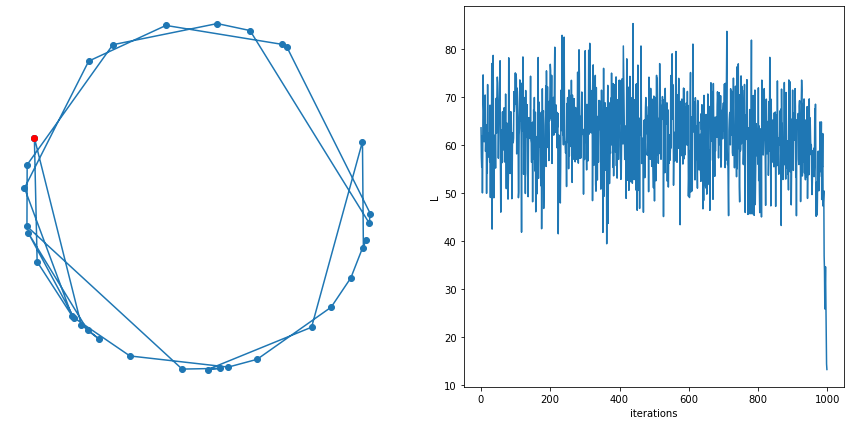

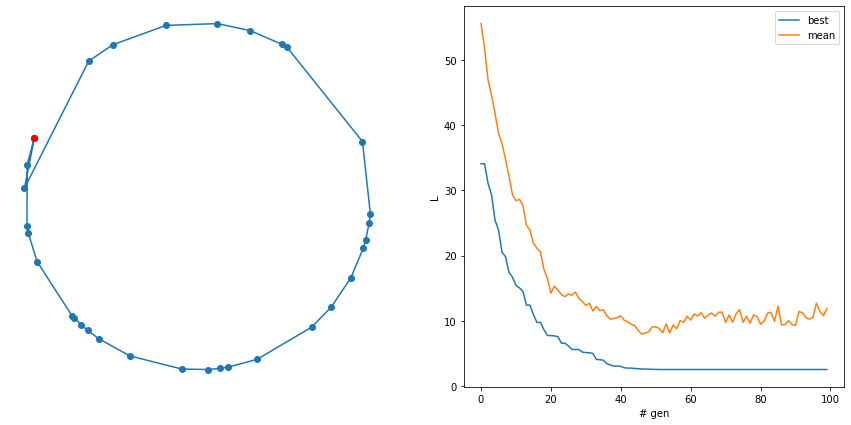

In [49]:
tspSA(cities_circle)
tspGA(cities_circle)

In the situation around a circle our best extimation with both method is set at:
- SA :
- GA :
We've already commented the GA result in exercise 9, the SA algorithm situation differ from our expectation, when in low temperature our model is capable of identify the minimum but this happen only in the final stage of the simulation.

The best path plot show a lot of variation in the run, even at low temperature, which make us wonder in possible error in our encoding, we've tried to vary the number of Monte Carlo steps added in every iteration and to increase iteration in the low temperature range. 

The first solution decrease the variation but make the result worst, the other situation does not solve the oscillation problem.

## 10.2

Parallelize with MPI libraries your Genetic Algorithm code in order to solve the TSP by performing a *Genetic Search* with 4 **parallel GA searches of the optimal path**:
each node should perform an independent GA search the so-called *Continents*, **but** every $N_{migr}$ generations the *Continents* should exchange their best individuals randomly.
Apply your code to the TSP problem for 32 cities randomly placed inside a square and try to estimate if your performances improve with *Continents*.

In the following part we present our results with our parallelized Genetic Algortihm and our results for a 4 parallel searches with random excange of the best individuals.

In [64]:
%%bash
module load mpi/openmpi-x86_64
# Or launch JupyterLab from a shell where you loaded the appropriate module (eg, mpi/openmpi-x86_64)

In [2]:
import numpy as np
from matplotlib import pyplot as plt
import subprocess
import os
import re

NUM_CITIES = 32

# hyperparameters
POP_SIZE = 200 # population size, should be even
NUM_GENERATIONS = 100
MUTATION_PROB = 0.1 # probability of each mutation
CROSSOVER_PROB = 0.5
POWER_LAW_EXPONENT = 4

WORKERS = 4
BATCH_SIZE = 3

# square
cities = np.random.rand(NUM_CITIES, 2)

In [3]:
path = os.path.join(os.getcwd(), "10/")
#Create imput file to run the TSP program
def create_input_file(pop_size, num_gen, mutation_prob, xover_prob, powerlaw_exp, num_mpi_gen_migr):
    with open(path + "config", 'w') as new_config:
        with open(path + "config.orig", 'r') as template_config:
            config = template_config.read()
            config = re.sub("{POP_SIZE}", str(pop_size), config)
            config = re.sub("{NUM_GENERATIONS}", str(num_gen), config)
            config = re.sub("{MUTATION_PROB}", str(mutation_prob), config)
            config = re.sub("{CROSSOVER_PROB}", str(xover_prob), config)
            config = re.sub("{POWER_LAW_EXPONENT}", str(powerlaw_exp), config)
            config = re.sub("{NUM_MPI_GEN_MIGR}", str(powerlaw_exp), config)
            new_config.write(config)
def tsp(cities):
    CITIES_FILE = 'cities'
    np.savetxt(f'{path}{CITIES_FILE}', cities, delimiter=' ', fmt='%1.5f')
    L = np.empty(NUM_GENERATIONS//2)
    for num_mpi_gen_migr in range(NUM_GENERATIONS//2):
        create_input_file(POP_SIZE, NUM_GENERATIONS, MUTATION_PROB, CROSSOVER_PROB, POWER_LAW_EXPONENT, num_mpi_gen_migr)
        for i in range(BATCH_SIZE):
            L[num_mpi_gen_migr] += float(subprocess.run(["mpiexec", "-n", f"{WORKERS}", "./main", f"{CITIES_FILE}", "config"], cwd=path, capture_output=True).stdout.decode("utf-8").split('\n')[0])
            #print(num_mpi_gen_migr)
    
 #plt.subplot(122)#
    plt.plot(L/BATCH_SIZE)
    plt.xlabel('# gen')
    plt.ylabel('L')
    plt.legend();


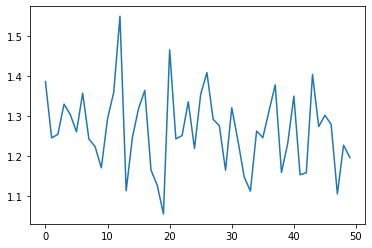

In [71]:
tsp(cities)

We've evaluate the result in function of the numbers of time that our best individual are exchange between continents. 

Our simulation has the following set up:
- The size of our population (series of possible travels in this case) set at $2\times10^2$
- The numbers of generations set at $100$
- The Mutation probability set at $10$%
- The Crossover probability set at $50$%
- The power law exponential for the selection operator $p = 4$
- The numbers of exchange between continents varing from $1$ every $100$ generation to $1$ every generation.

As can be seen by our result it seems that the reult does not improve much increasing the exchange between continents.